## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.fft import fft, ifft
from scipy.signal import find_peaks
from scipy.signal.windows import hann
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
# Load and preprocess data
data = pd.read_csv(r'C:\Users\trieu\OneDrive\Documents\HK2_2024\IS403\IS403_BA\IS403_O22_HTCL_2\Dataset\AMV Historical Data.csv')
df = data.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df = df.replace(',', '', regex=True)

In [3]:
# Select 'Price' column and handle missing values
price_data = df['Price'].astype(float).interpolate()

In [4]:
# Remove outliers (simple Z-score method)
z_scores = np.abs((price_data - price_data.mean()) / price_data.std())
price_data = price_data[z_scores < 3]

In [5]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(price_data.values.reshape(-1, 1))

In [6]:
# Split data
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

In [7]:
# Perform FFT with windowing and noise filtering
def fft_transform(data, num_frequencies=10):
    n = len(data)
    window = hann(n)
    fft_result = fft(data * window)
    frequencies = np.fft.fftfreq(n)
    
    # Noise filtering: Keep only top frequencies
    top_indices = np.argsort(np.abs(fft_result))[-num_frequencies:]
    filtered_fft = np.zeros_like(fft_result)
    filtered_fft[top_indices] = fft_result[top_indices]
    
    return filtered_fft, frequencies


In [8]:
# Inverse FFT
def ifft_transform(fft_result):
    return np.real(ifft(fft_result))

In [9]:
# New prediction function using only FFT
def predict_fft(data, fft_result, days):
    n = len(data)
    extended_fft = np.zeros(n + days, dtype=complex)
    extended_fft[:n] = fft_result
    fft_pred = ifft_transform(extended_fft)[-days:]
    return np.maximum(fft_pred, 0)  # Ensure non-negative values

In [10]:
# Identify cycles
def identify_cycles(data, frequencies):
    fft_result = fft(data)
    power_spectrum = np.abs(fft_result)**2
    peaks, _ = find_peaks(power_spectrum)
    cycle_lengths = 1 / np.abs(frequencies[peaks])
    cycle_strengths = power_spectrum[peaks]
    return cycle_lengths, cycle_strengths

# Frequency analysis
def analyze_frequencies(fft_result, frequencies):
    magnitudes = np.abs(fft_result)
    top_indices = np.argsort(magnitudes)[-10:]  # Top 10 frequencies
    top_frequencies = frequencies[top_indices]
    top_magnitudes = magnitudes[top_indices]
    return top_frequencies, top_magnitudes

In [11]:
# Optimize number of frequencies
tscv = TimeSeriesSplit(n_splits=5)
best_mse = float('inf')
best_num_freq = 0

for num_freq in range(5, 51, 5):
    mse_scores = []
    for train_index, val_index in tscv.split(train_data):
        train_subset = train_data[train_index]
        val_subset = train_data[val_index]
        
        train_fft, _ = fft_transform(train_subset.flatten(), num_frequencies=num_freq)
        pred = predict_fft(train_subset, train_fft, len(val_subset))
        mse = mean_squared_error(val_subset, pred)
        mse_scores.append(mse)
    
    avg_mse = np.mean(mse_scores)
    if avg_mse < best_mse:
        best_mse = avg_mse
        best_num_freq = num_freq

print(f"Best number of frequencies: {best_num_freq}")

Best number of frequencies: 5


In [12]:
# Recompute FFT with best number of frequencies
train_fft, train_frequencies = fft_transform(train_data.flatten(), num_frequencies=best_num_freq)

# Identify cycles in the training data
cycle_lengths, cycle_strengths = identify_cycles(train_data.flatten(), train_frequencies)

# Analyze frequencies
top_frequencies, top_magnitudes = analyze_frequencies(train_fft, train_frequencies)

# Predict for test data
filtered_test = predict_fft(train_data, train_fft, len(test_data))

In [13]:
# Predict future values
future_data = np.concatenate((train_data, test_data))
future_fft, _ = fft_transform(future_data.flatten(), num_frequencies=best_num_freq)
y_next_30_days = predict_fft(future_data, future_fft, 30)
y_next_60_days = predict_fft(future_data, future_fft, 60)
y_next_90_days = predict_fft(future_data, future_fft, 90)

In [14]:
# Calculate error metrics
test_mape = mean_absolute_percentage_error(test_data, filtered_test.reshape(-1, 1))
test_mse = mean_squared_error(test_data, filtered_test.reshape(-1, 1))
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(test_data, filtered_test.reshape(-1, 1))

print(f"MAPE on Test set: {test_mape}")
print(f"RMSE on Test set: {test_rmse}")
print(f"MSLE on Test set: {test_msle}")

MAPE on Test set: 1.4337177125652665
RMSE on Test set: 0.09491579875830389
MSLE on Test set: 0.007119994438388043


In [15]:
# Inverse transform predictions
filtered_test = scaler.inverse_transform(filtered_test.reshape(-1, 1)).flatten()
y_next_30_days = scaler.inverse_transform(y_next_30_days.reshape(-1, 1)).flatten()
y_next_60_days = scaler.inverse_transform(y_next_60_days.reshape(-1, 1)).flatten()
y_next_90_days = scaler.inverse_transform(y_next_90_days.reshape(-1, 1)).flatten()

# Print predictions
print("Predicted next 30 days:")
print(y_next_30_days)
print("\nPredicted next 60 days:")
print(y_next_60_days)
print("\nPredicted next 90 days:")
print(y_next_90_days)

# Print predictions
print("Predicted next 30 days:")
print(y_next_30_days)
print("\nPredicted next 60 days:")
print(y_next_60_days)
print("\nPredicted next 90 days:")
print(y_next_90_days)


Predicted next 30 days:
[6436.39695513 6699.88269809 6922.52437008 7099.55660036 7227.1549119
 7302.51820731 7323.93011618 7290.79785933 7203.66775095 7064.21694495
 6875.22152702 6640.50154869 6364.84408322 6053.90584622 5714.09735559
 5352.45099773 4976.4757108  4594.00128383 4213.01549749 3841.49749143
 3487.25083316 3157.73977993 2859.93216937 2700.         2700.
 2700.         2700.         2700.         2700.         2700.        ]

Predicted next 60 days:
[6643.71618575 6983.26493711 7147.54956663 7123.35760949 6911.98657656
 6529.17937192 6003.94523683 5376.35432595 4694.47342612 4010.6770219
 3377.6167174  2844.15912472 2700.         2700.         2700.
 2700.         2700.         3189.55240855 3798.62201617 4476.97612249
 5172.32625646 5830.94663025 6401.81869855 6840.57728091 7112.95303955
 7197.4441808  7087.00905488 6789.64638197 6327.81538256 5736.73755815
 5061.70835665 4354.62377613 3669.98815076 3060.71015372 2700.
 2700.         2700.         2700.         2700.     

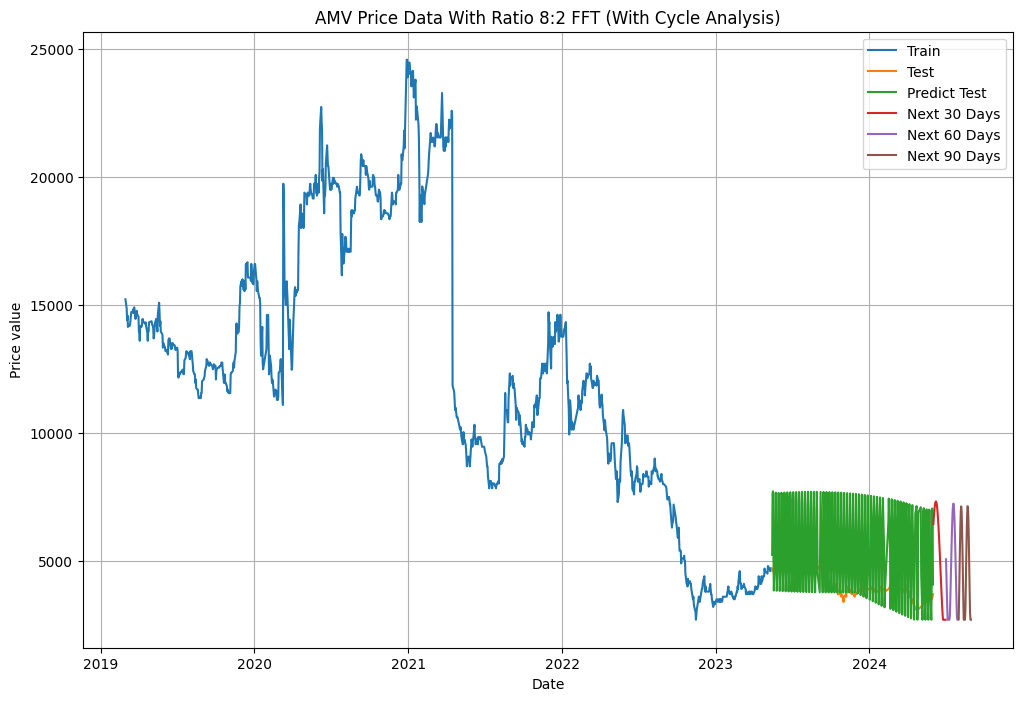

In [16]:
# Create DataFrames for plotting
train_data_df = pd.DataFrame(scaler.inverse_transform(train_data), index=df.index[:train_size], columns=['Price'])
test_data_df = pd.DataFrame(scaler.inverse_transform(test_data), index=df.index[train_size:], columns=['Price'])
filtered_test_df = pd.DataFrame(filtered_test, index=df.index[train_size:train_size+len(filtered_test)], columns=['Predict Test'])
next_30_days_df = pd.DataFrame(y_next_30_days, index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=30), columns=['Next 30 Days'])
next_60_days_df = pd.DataFrame(y_next_60_days[30:], index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=31), periods=30), columns=['Next 60 Days'])
next_90_days_df = pd.DataFrame(y_next_90_days[60:], index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=61), periods=30), columns=['Next 90 Days'])

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(train_data_df.index, train_data_df['Price'], label='Train')
plt.plot(test_data_df.index, test_data_df['Price'], label='Test')
plt.plot(filtered_test_df.index, filtered_test_df['Predict Test'], label='Predict Test')
plt.plot(next_30_days_df.index, next_30_days_df['Next 30 Days'], label='Next 30 Days')
plt.plot(next_60_days_df.index, next_60_days_df['Next 60 Days'], label='Next 60 Days')
plt.plot(next_90_days_df.index, next_90_days_df['Next 90 Days'], label='Next 90 Days')
plt.legend()
plt.grid()
plt.title("AMV Price Data With Ratio 8:2 FFT (With Cycle Analysis)")
plt.xlabel("Date")
plt.ylabel("Price value")
plt.savefig('FFT_82_AMV.png')
plt.show()

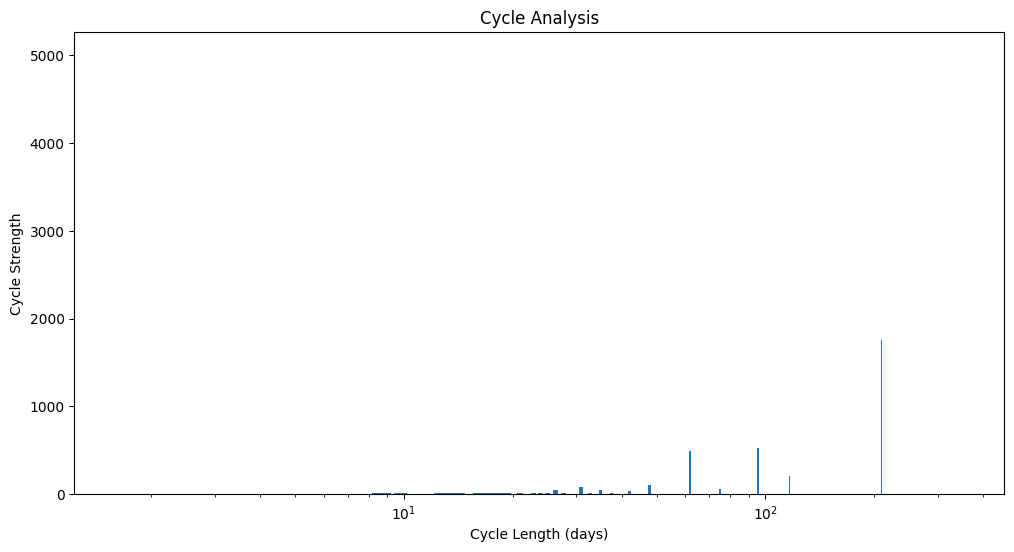

C:\Users\trieu\AppData\Local\Temp\ipykernel_18924\1157745247.py:13: RuntimeWarning: divide by zero encountered in divide
  plt.bar(1/top_frequencies, top_magnitudes)
c:\Python312\Lib\site-packages\matplotlib\transforms.py:2048: RuntimeWarning: invalid value encountered in scalar add
  self._mtx[0, 2] += tx
c:\Python312\Lib\site-packages\matplotlib\transforms.py:372: RuntimeWarning: invalid value encountered in scalar subtract
  return (x0, y0, x1 - x0, y1 - y0)


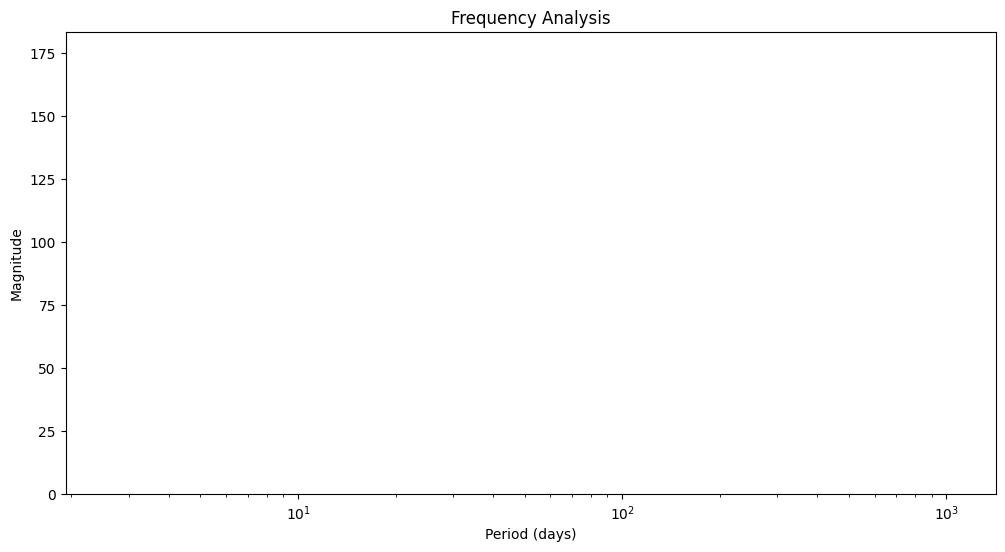


Top 5 Cycles:
Length: 350.00 days, Strength: 5012.83
Length: 210.00 days, Strength: 1757.24
Length: 150.00 days, Strength: 726.45
Length: 116.67 days, Strength: 202.16
Length: 95.45 days, Strength: 524.67

Top 5 Frequencies:
Period: 3.03 days, Magnitude: 0.00
Period: 3.03 days, Magnitude: 0.00
Period: 3.04 days, Magnitude: 0.00
Period: 2.99 days, Magnitude: 0.00
Period: -262.50 days, Magnitude: 0.00


In [17]:
# Plot cycle analysis
plt.figure(figsize=(12, 6))
plt.bar(cycle_lengths, cycle_strengths)
plt.title("Cycle Analysis")
plt.xlabel("Cycle Length (days)")
plt.ylabel("Cycle Strength")
plt.xscale('log')
plt.savefig('CycleAnalysis.png')
plt.show()

# Plot frequency analysis
plt.figure(figsize=(12, 6))
plt.bar(1/top_frequencies, top_magnitudes)
plt.title("Frequency Analysis")
plt.xlabel("Period (days)")
plt.ylabel("Magnitude")
plt.xscale('log')
plt.savefig('FrequencyAnalysis.png')
plt.show()

# Print cycle and frequency analysis results
print("\nTop 5 Cycles:")
for length, strength in zip(cycle_lengths[:5], cycle_strengths[:5]):
    print(f"Length: {length:.2f} days, Strength: {strength:.2f}")

print("\nTop 5 Frequencies:")
for freq, mag in zip(top_frequencies[:5], top_magnitudes[:5]):
    print(f"Period: {1/freq:.2f} days, Magnitude: {mag:.2f}")